In [1]:
import torch, shap, glob, os
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random


from tqdm.notebook import tqdm
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
npy_path = './np_image_totalunit/multiclass_TCAGN-_400px/'
# npy_path = './np_image_totalunit/multiclass_totalunit/'

save_weight_path ='./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/'
if not os.path.exists(save_weight_path):
    os.mkdir(save_weight_path)

# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [4]:
label_[0:30]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5,
       3, 5, 3, 3, 3, 3, 3, 3])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

1053 1053
351 351


In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [7]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

1053 351


In [8]:
from torchvision.models import alexnet, resnet18
from torch.nn import Module
from torch import nn
# model = resnet18(pretrained=False, num_classes=max(label_)+1)
model = alexnet(pretrained=False, num_classes=max(label_)+1)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model

In [9]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# loss_func = nn.CrossEntropyLoss(reduction="sum", weight=class_weights)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)
# path2weights = "./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.22.pt"
# torch.save(model.state_dict(), path2weights)
params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2weights,
    }

In [10]:
import copy
import datetime
from tqdm import tqdm_notebook
from sklearn import metrics
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

class logs_realtime_reply:
    def __init__(self):
        self.avg_loss=np.inf
        self.running_metic = {"Loss":0, "Accuracy":0}
        self.end_epoch_metric = None
    def metric_stack(self, inputs, targets, loss):

        classes = torch.argmax(inputs, dim=1)
        self.running_metic['Loss'] +=loss
        classes = torch.argmax(inputs, dim=1)
        acc = torch.mean((classes == targets).float())
        self.running_metic['Accuracy'] += np.round(acc.cpu().numpy(), 5)*100

    def mini_batch_reply(self, current_step, epoch, iter_len):
        # avg_reply_metric = {"Loss":None, "TP":None, "FP":None, "FN": None, "Spec": None, "Sens": None}
        avg_reply_metric = {"Loss":None, "Accuracy": None}
        for j in avg_reply_metric:
            avg_reply_metric[j] = round(self.running_metic[j]/int(current_step),5)
        
        if current_step ==iter_len:
            self.end_epoch_metric = avg_reply_metric
        return avg_reply_metric
    def epoch_reply(self):
        return self.end_epoch_metric
        
def train(train_loader, model, criterion, optimizer, epoch):
    get_logs_reply = logs_realtime_reply()
    model.train()
    stream = tqdm(train_loader)
   
    for i, (image, label) in enumerate(stream, start=1):
        image=image.to(device)
        label=label.to(device)
        output=model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        
        get_logs_reply.metric_stack(output, label, loss = round(loss.item(), 5))
        avg_reply_metric = get_logs_reply.mini_batch_reply(i, epoch, len(stream))
        avg_reply_metric['lr'] = optimizer.param_groups[0]['lr']
        stream.set_description(f"Epoch: {epoch}. Train. {str(avg_reply_metric)}")
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy']
# model validate
def validate(valid_loader, model, criterion, epoch):
    global best_vloss, best_vacc
    get_logs_reply2 = logs_realtime_reply()
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, (image, label) in enumerate(stream_v, start=1):
            image=image.to(device)
            label=label.to(device)
            output=model(image)
            loss = criterion(output, label)
            get_logs_reply2.metric_stack(output, label, loss = round(loss.item(), 5))
            avg_reply_metric = get_logs_reply2.mini_batch_reply(i, epoch, len(stream_v))
            stream_v.set_description(f"Epoch: {epoch}. Valid. {str(avg_reply_metric)}")
        avg_reply_metric = get_logs_reply2.epoch_reply()

    for x in avg_reply_metric:
        if x=='Loss' and avg_reply_metric[x]<best_vloss:
            best_vloss = avg_reply_metric[x]
            current_loss = avg_reply_metric['Loss']
            best_ck_name = path2weights
            torch.save({
                    'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), 
                    'loss':  current_loss,}, best_ck_name)
            print('save...', best_ck_name)
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy']



def  train_valid_process_main(model):
    global best_vloss, best_vacc
    best_vloss = np.inf
    best_vacc = 0.00
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    # Subject Dataloader Building
    batch_size = 32
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                            shuffle=True)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                            shuffle=False)  

    for epoch in range(1, params_train["num_epochs"] + 1):
        train_loss, train_metric = train(train_dl, model, loss_func, opt, epoch)
        val_loss, val_metric = validate(test_dl, model, loss_func, epoch)
        print("Epoch: ",epoch, f" Train/Valid Loss: {train_loss}|{val_loss}  ", f" Train/Valid Accuracy: {train_metric}|{val_metric}")
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        lr_scheduler.step(val_loss)
    return loss_history, metric_history

In [11]:
loss_history, metric_history  = train_valid_process_main(model)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  1  Train/Valid Loss: 28.70189|42.02848    Train/Valid Accuracy: 81.6843|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  2  Train/Valid Loss: 22.97718|40.90597    Train/Valid Accuracy: 84.35539|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  3  Train/Valid Loss: 23.25134|52.52941    Train/Valid Accuracy: 84.31621|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  4  Train/Valid Loss: 23.61698|40.74191    Train/Valid Accuracy: 84.33582|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  5  Train/Valid Loss: 23.22895|40.8007    Train/Valid Accuracy: 84.29664|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  6  Train/Valid Loss: 22.87479|40.8348    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  7  Train/Valid Loss: 22.95124|40.90563    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  8  Train/Valid Loss: 22.97729|42.70433    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  9  Train/Valid Loss: 23.66105|41.0443    Train/Valid Accuracy: 84.35539|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  10  Train/Valid Loss: 22.73733|40.80997    Train/Valid Accuracy: 84.34561|84.56817
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  11  Train/Valid Loss: 22.89836|40.73016    Train/Valid Accuracy: 84.30642|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  12  Train/Valid Loss: 22.76475|40.71668    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  13  Train/Valid Loss: 22.62005|41.52349    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  14  Train/Valid Loss: 22.81251|41.45631    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  15  Train/Valid Loss: 22.88919|40.83801    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  16  Train/Valid Loss: 22.87809|40.70292    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  17  Train/Valid Loss: 22.51305|40.6406    Train/Valid Accuracy: 84.30642|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  18  Train/Valid Loss: 22.42207|41.06948    Train/Valid Accuracy: 84.30642|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  19  Train/Valid Loss: 22.67209|40.70198    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  20  Train/Valid Loss: 22.52204|41.61703    Train/Valid Accuracy: 84.33582|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  21  Train/Valid Loss: 22.87706|40.75022    Train/Valid Accuracy: 84.33582|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  22  Train/Valid Loss: 22.39235|40.86299    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  23  Train/Valid Loss: 22.61462|40.7388    Train/Valid Accuracy: 84.31621|84.56817
Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  24  Train/Valid Loss: 22.4378|40.7126    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  25  Train/Valid Loss: 22.43844|40.61672    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  26  Train/Valid Loss: 22.23898|41.34204    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  27  Train/Valid Loss: 22.29918|40.88924    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  28  Train/Valid Loss: 22.35092|40.59718    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  29  Train/Valid Loss: 22.58189|41.86568    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  30  Train/Valid Loss: 22.41022|40.92001    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  31  Train/Valid Loss: 22.54679|40.89085    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  32  Train/Valid Loss: 22.15545|40.70126    Train/Valid Accuracy: 84.33582|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  33  Train/Valid Loss: 22.20743|40.54686    Train/Valid Accuracy: 84.35539|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  34  Train/Valid Loss: 22.28616|40.60823    Train/Valid Accuracy: 84.30642|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  35  Train/Valid Loss: 21.77784|40.38485    Train/Valid Accuracy: 84.30642|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  36  Train/Valid Loss: 22.25557|40.56628    Train/Valid Accuracy: 84.32603|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  37  Train/Valid Loss: 21.61957|38.31634    Train/Valid Accuracy: 84.33582|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  38  Train/Valid Loss: 17.94252|23.99967    Train/Valid Accuracy: 84.34561|84.56817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  39  Train/Valid Loss: 11.51063|17.12039    Train/Valid Accuracy: 88.04858|91.3725


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  40  Train/Valid Loss: 9.38183|16.03406    Train/Valid Accuracy: 91.46748|91.8935


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  41  Train/Valid Loss: 8.56925|14.3853    Train/Valid Accuracy: 92.11076|91.8935


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  42  Train/Valid Loss: 7.57107|12.42844    Train/Valid Accuracy: 93.73039|94.77467


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  43  Train/Valid Loss: 7.10587|10.95217    Train/Valid Accuracy: 94.29858|95.035


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  44  Train/Valid Loss: 6.2739|10.66182    Train/Valid Accuracy: 94.66758|95.035


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  45  Train/Valid Loss: 6.97765|10.96827    Train/Valid Accuracy: 94.0047|95.03517


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  46  Train/Valid Loss: 6.09209|11.59625    Train/Valid Accuracy: 94.50758|94.77483


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  47  Train/Valid Loss: 6.55096|10.33139    Train/Valid Accuracy: 94.41288|95.035


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  48  Train/Valid Loss: 6.19736|11.14859    Train/Valid Accuracy: 94.57288|94.77467


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  49  Train/Valid Loss: 6.37521|13.34028    Train/Valid Accuracy: 94.45861|94.254


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  50  Train/Valid Loss: 5.5951|9.93426    Train/Valid Accuracy: 94.59248|95.2955


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  51  Train/Valid Loss: 5.78984|10.69824    Train/Valid Accuracy: 94.49779|95.2955


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  52  Train/Valid Loss: 5.31748|9.89944    Train/Valid Accuracy: 94.78188|95.556


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  53  Train/Valid Loss: 4.75931|10.31047    Train/Valid Accuracy: 95.82355|96.07683


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  54  Train/Valid Loss: 4.3495|9.89147    Train/Valid Accuracy: 95.71903|95.8165


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  55  Train/Valid Loss: 4.58861|10.23509    Train/Valid Accuracy: 95.62433|95.03533


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  56  Train/Valid Loss: 4.50928|9.11645    Train/Valid Accuracy: 95.44476|95.2955


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  57  Train/Valid Loss: 4.43074|9.85004    Train/Valid Accuracy: 95.91824|95.03517


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  58  Train/Valid Loss: 4.43265|9.47182    Train/Valid Accuracy: 95.45455|94.254


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  59  Train/Valid Loss: 4.27286|9.60267    Train/Valid Accuracy: 96.30682|96.33733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  60  Train/Valid Loss: 4.21532|8.61095    Train/Valid Accuracy: 96.38191|96.33733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  61  Train/Valid Loss: 3.7045|8.00151    Train/Valid Accuracy: 96.95991|96.85833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  62  Train/Valid Loss: 2.93302|9.19229    Train/Valid Accuracy: 97.52809|96.33733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  63  Train/Valid Loss: 3.63169|8.71055    Train/Valid Accuracy: 96.68561|96.85833


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  64  Train/Valid Loss: 3.13745|7.92145    Train/Valid Accuracy: 96.86521|96.85817


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  65  Train/Valid Loss: 3.03612|7.0963    Train/Valid Accuracy: 97.3387|97.11883


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  66  Train/Valid Loss: 3.32807|8.51109    Train/Valid Accuracy: 97.43339|96.598


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  67  Train/Valid Loss: 3.5889|7.46063    Train/Valid Accuracy: 97.244|96.8585


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  68  Train/Valid Loss: 3.22092|6.76228    Train/Valid Accuracy: 97.44318|97.11867


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  69  Train/Valid Loss: 2.87956|6.14338    Train/Valid Accuracy: 97.62279|98.17717


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  70  Train/Valid Loss: 2.60768|6.74424    Train/Valid Accuracy: 97.82197|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  71  Train/Valid Loss: 2.67316|6.55406    Train/Valid Accuracy: 97.91667|97.11867


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  72  Train/Valid Loss: 3.08205|8.76785    Train/Valid Accuracy: 97.53788|97.11867


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  73  Train/Valid Loss: 2.27708|7.55785    Train/Valid Accuracy: 97.63258|97.63967


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  74  Train/Valid Loss: 2.52482|6.36403    Train/Valid Accuracy: 98.29545|97.9


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  75  Train/Valid Loss: 2.59053|6.59826    Train/Valid Accuracy: 97.90688|98.43767
Epoch 00075: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  76  Train/Valid Loss: 1.88689|6.19324    Train/Valid Accuracy: 98.47506|97.37933


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  77  Train/Valid Loss: 2.27196|6.05365    Train/Valid Accuracy: 98.28567|97.63967


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  78  Train/Valid Loss: 1.71225|6.52411    Train/Valid Accuracy: 98.75915|97.9


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  79  Train/Valid Loss: 1.95549|6.55532    Train/Valid Accuracy: 98.39015|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  80  Train/Valid Loss: 1.90555|6.37952    Train/Valid Accuracy: 98.47506|97.63967


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  81  Train/Valid Loss: 1.88382|6.08396    Train/Valid Accuracy: 98.27585|97.63967


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  82  Train/Valid Loss: 1.81769|7.47153    Train/Valid Accuracy: 98.39015|98.1605


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  83  Train/Valid Loss: 2.20108|6.17735    Train/Valid Accuracy: 98.38036|97.63967
Epoch 00083: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  84  Train/Valid Loss: 1.43772|6.15969    Train/Valid Accuracy: 98.75915|97.63967


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  85  Train/Valid Loss: 1.63914|6.75118    Train/Valid Accuracy: 98.86364|97.9


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

save... ./models/weights_alex_multiclass_Covid19(Non-kmer3)_.2022.04.21[TCAGN-]_400px/weights_multiclass_Covid19(Non-kmer3)[TCAGN-].2022.04.21.pt
Epoch:  86  Train/Valid Loss: 1.64858|5.98445    Train/Valid Accuracy: 98.86364|97.37933


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  87  Train/Valid Loss: 1.15486|6.29655    Train/Valid Accuracy: 98.95833|97.37933


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  88  Train/Valid Loss: 1.70252|6.3605    Train/Valid Accuracy: 98.67424|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  89  Train/Valid Loss: 1.33487|6.87789    Train/Valid Accuracy: 98.85385|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  90  Train/Valid Loss: 1.40152|6.90083    Train/Valid Accuracy: 98.86364|98.43767


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  91  Train/Valid Loss: 1.50306|6.87107    Train/Valid Accuracy: 98.86364|97.37933


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  92  Train/Valid Loss: 1.81642|7.09129    Train/Valid Accuracy: 98.56976|98.43767
Epoch 00092: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  93  Train/Valid Loss: 1.22149|6.77322    Train/Valid Accuracy: 99.14773|97.37933


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  94  Train/Valid Loss: 1.17976|6.94635    Train/Valid Accuracy: 98.85385|97.917


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  95  Train/Valid Loss: 1.03359|6.87024    Train/Valid Accuracy: 99.05303|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  96  Train/Valid Loss: 1.20405|7.0548    Train/Valid Accuracy: 99.04324|98.17733


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  97  Train/Valid Loss: 1.0434|7.03838    Train/Valid Accuracy: 99.23264|97.917


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  98  Train/Valid Loss: 1.2828|7.18894    Train/Valid Accuracy: 99.14773|97.917
Epoch 00098: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  99  Train/Valid Loss: 1.1386|7.13377    Train/Valid Accuracy: 98.94855|97.917


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  100  Train/Valid Loss: 1.10368|7.18815    Train/Valid Accuracy: 99.33712|98.17733


Text(0.5, 1.0, 'loss history')

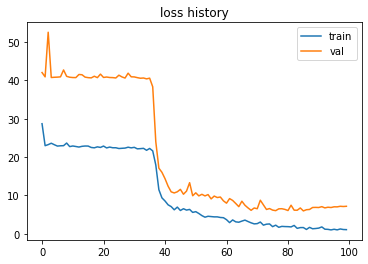

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title('loss history')

Text(0.5, 1.0, 'accuracy history')

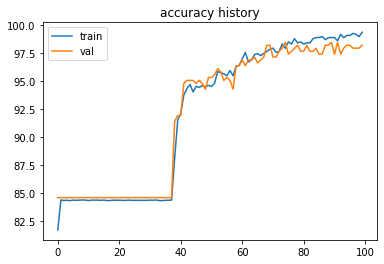

In [13]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title('accuracy history')